In [43]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

from tensorflow.keras import models
from keras.models import Model


In [69]:
N = 11788
t = 64
epoch = 0

In [45]:
import torch

# Read data from text file
with open("CUB_200_2011/train_test_split.txt", "r") as file:
    data = file.readlines()

# Convert data to list of floats
data = [list(map(int, line.strip().split())) for line in data]

# Convert list to tensor
tensor_data = torch.tensor(data)



In [46]:
train_index = []
test_index = []

for i in range(0,N):
    if tensor_data[i][1] == 1:
        train_index.append(i)
    else:
        test_index.append(i) 

In [47]:
# Read data from text file
with open("CUB_200_2011/image_class_labels.txt", "r") as file:
    data = file.readlines()

# Convert data to list of floats
data = [list(map(int, line.strip().split())) for line in data]

# Convert list to tensor
class_labels_num = torch.tensor(data)

y_train = []
y_test = []
for i in range(0, N):
    if i in train_index:
        y_train.append(int(class_labels_num[i][1]))
    else:
        y_test.append(int(class_labels_num[i][1]))

In [48]:
# Open the file
with open("CUB_200_2011/images.txt", 'r') as file:
    # Read all lines into a list
    lines = file.readlines()

# Initialize an empty list for the 2D array
data = []

# Iterate over each line and split numbers and links
for line in lines:
    # Split the line by whitespace
    parts = line.split()
    # Extract the number and link
    num = int(parts[0])  # Assuming the number is at the beginning of each line
    link = ' '.join(parts[1:])  # Join the remaining parts as the link
    link= ".//CUB_200_2011//images//"+link
    data.append([num, link])

# Convert the list of lists to a NumPy array
data_array = np.array(data)

# Now you have 'data_array' containing both numbers and links as a 2D array
# You can access individual elements or slices as needed



In [49]:
from PIL import Image
import numpy as np

# Assuming you have 'data_array' containing the links and 'train_index' containing indices from 1 to 11788

# Initialize empty lists for storing images
x_train = []
x_test = []

# Iterate over the 2D array and load and resize images
for i, item in enumerate(data_array, start=1):  # Start enumeration from index 1
    # Get the link from the second index
    link = item[1]
    # Load the image from the link
    try:
        image = Image.open(link)
        # Resize the image to 32x32 pixels
        resized_image = image.resize((t, t))
        # Convert the resized image to a NumPy array
        resized_image_array = np.array(resized_image)
        # Check if i is in train_index
        if i in train_index:
            # Append the resized image to x_train if i is in train_index
            x_train.append(resized_image_array)
        else:
            # Append the resized image to x_test if i is not in train_index
            x_test.append(resized_image_array)
    except Exception as e:
        print(f"Error loading image from {link}: {e}")

# Now x_train contains the resized images loaded from the links corresponding to indices present in train_index
# and x_test contains the resized images loaded from the links corresponding to indices not present in train_index


In [50]:
deleted_test_sample_index = [] #this index is with respect test sample 
deleted_train_sample_index = [] #This index is with respect to train sample

# deleting samples having no RGB dimensions (Number of such images are very less. so deleting them seems to be a good option)
for i in range(len(x_test)):
    if (x_test[i].shape)!=(t,t,3):
        deleted_test_sample_index.append(i)
        print(f'{i}th element of x test is found inhomogenous')
for j in range(len(x_train)):
    if (x_train[j].shape)!=(t,t,3):
        deleted_train_sample_index.append(j)
        print(f'{j}th element of x train is found inhomogenous')

print(deleted_test_sample_index)
print(deleted_train_sample_index)
#print(x_train[1867].shape)

195th element of x test is found inhomogenous
3081th element of x test is found inhomogenous
749th element of x train is found inhomogenous
1868th element of x train is found inhomogenous
1869th element of x train is found inhomogenous
1951th element of x train is found inhomogenous
2580th element of x train is found inhomogenous
2762th element of x train is found inhomogenous
[195, 3081]
[749, 1868, 1869, 1951, 2580, 2762]


In [51]:
for i in range(len(deleted_test_sample_index)):
    x_test.pop(deleted_test_sample_index[i]-i)
    y_test.pop(deleted_test_sample_index[i]-i)
    print(deleted_test_sample_index[i])

for i in range(len(deleted_train_sample_index)):
    x_train.pop(deleted_train_sample_index[i]-i)
    y_train.pop(deleted_train_sample_index[i]-i)
    print(deleted_train_sample_index[i])


195
3081
749
1868
1869
1951
2580
2762


In [52]:
x_train = np.array(x_train)
x_test = np.array(x_test)
print(x_train.shape)
print(x_test.shape)

(5988, 64, 64, 3)
(5792, 64, 64, 3)


In [53]:
# Normalize images to the range [0, 1].
x_train = x_train.astype("float32") / 255
x_test  = x_test.astype("float32") / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
 

In [79]:

import efficientnet.keras as efn
base_model = efn.EfficientNetB0(input_shape = (t, t, 3), include_top = False, weights = 'imagenet')


fine_tune = 7

for layer in base_model.layers:
            layer.trainable = False

if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = True


In [80]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(201, activation="softmax")(x)
model = Model(base_model.input, x)

In [81]:
from keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [60]:
epoch = 100
eff_history = model.fit(x_train,
                        y_train,
                        batch_size=256, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_split=.25)


Epoch 1/100
18/18 [==============================] - 15s 817ms/step - loss: 0.0267 - acc: 0.1033 - val_loss: 0.0447 - val_acc: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 15s 854ms/step - loss: 0.0265 - acc: 0.1100 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 15s 869ms/step - loss: 0.0262 - acc: 0.1216 - val_loss: 0.0450 - val_acc: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 16s 906ms/step - loss: 0.0260 - acc: 0.1200 - val_loss: 0.0450 - val_acc: 0.0000e+00
Epoch 5/100
18/18 [==============================] - 19s 1s/step - loss: 0.0258 - acc: 0.1278 - val_loss: 0.0451 - val_acc: 0.0000e+00
Epoch 6/100
18/18 [==============================] - 16s 890ms/step - loss: 0.0255 - acc: 0.1316 - val_loss: 0.0451 - val_acc: 0.0000e+00
Epoch 7/100
18/18 [==============================] - 16s 900ms/step - loss: 0.0253 - acc: 0.1412 - val_loss: 0.0453 - val_acc: 0.0000e+00
Epoch 8/100
18/18 [==================

In [70]:
epoch =100

In [61]:
model.save('efficientnet_WB')

INFO:tensorflow:Assets written to: efficientnet_WB\assets


INFO:tensorflow:Assets written to: efficientnet_WB\assets


In [71]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, epoch])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

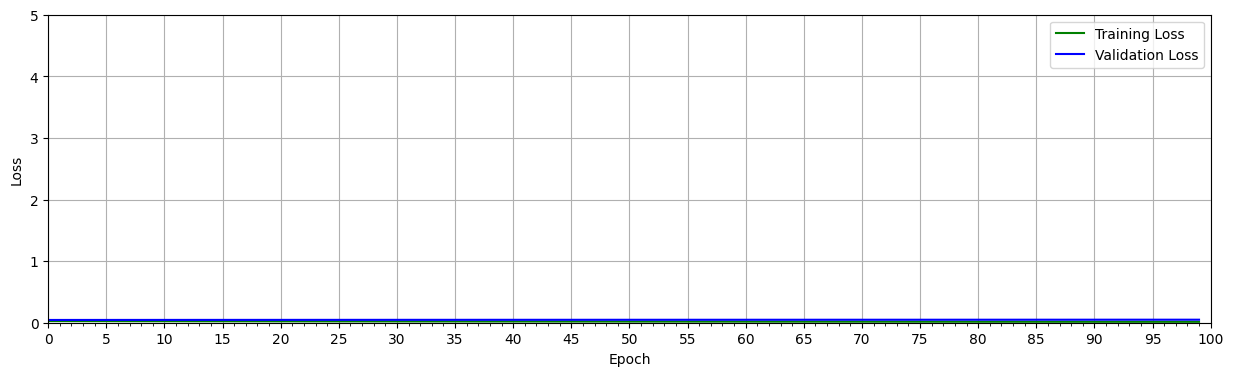

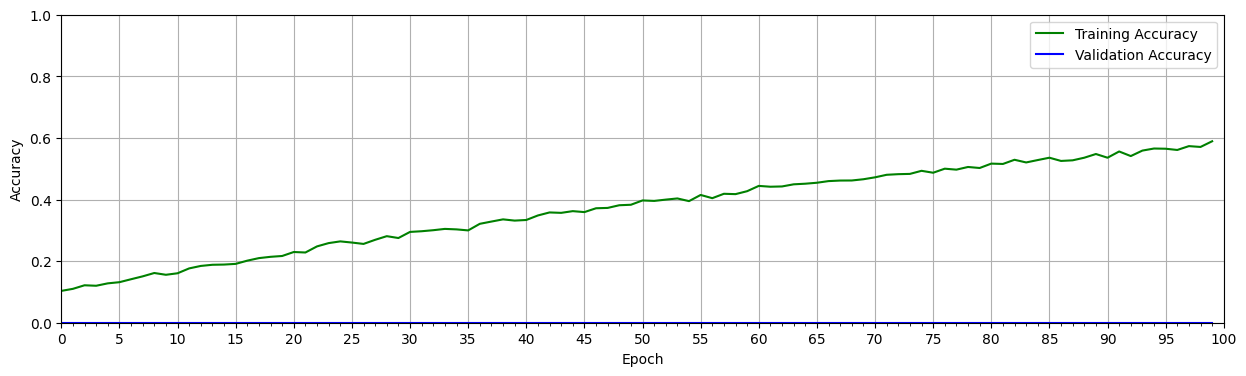

In [ ]:
#Retrieve training results.
train_loss = eff_history.history["loss"]
train_acc  = eff_history.history["acc"]
valid_loss = eff_history.history["val_loss"]
valid_acc  = eff_history.history["val_acc"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 0.03],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [63]:
reloaded_model_dropout = models.load_model('efficientnet_WB')
test_loss, test_acc = reloaded_model_dropout.evaluate(x_test, y_test)
print(f"Test accuracy (model without dropout): {test_acc*100:.3f}")

181/181 [==============================] - 27s 132ms/step - loss: 0.0307 - acc: 0.1126
Test accuracy (model without dropout): 11.257


In [75]:
epoch = 20
eff_history = model.fit(x_train,
                        y_train,
                        batch_size=256, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_split=.25)

model.save('efficientnet_WB')

Epoch 1/20
18/18 [==============================] - 18s 997ms/step - loss: 0.0132 - acc: 0.6406 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 17s 944ms/step - loss: 0.0128 - acc: 0.6564 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 17s 979ms/step - loss: 0.0130 - acc: 0.6397 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 17s 968ms/step - loss: 0.0129 - acc: 0.6542 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 18s 1s/step - loss: 0.0129 - acc: 0.6517 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 17s 973ms/step - loss: 0.0128 - acc: 0.6542 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 18s 1s/step - loss: 0.0128 - acc: 0.6486 - val_loss: 0.0500 - val_acc: 0.0000e+00
Epoch 8/20
18/18 [=============================

INFO:tensorflow:Assets written to: efficientnet_WB\assets


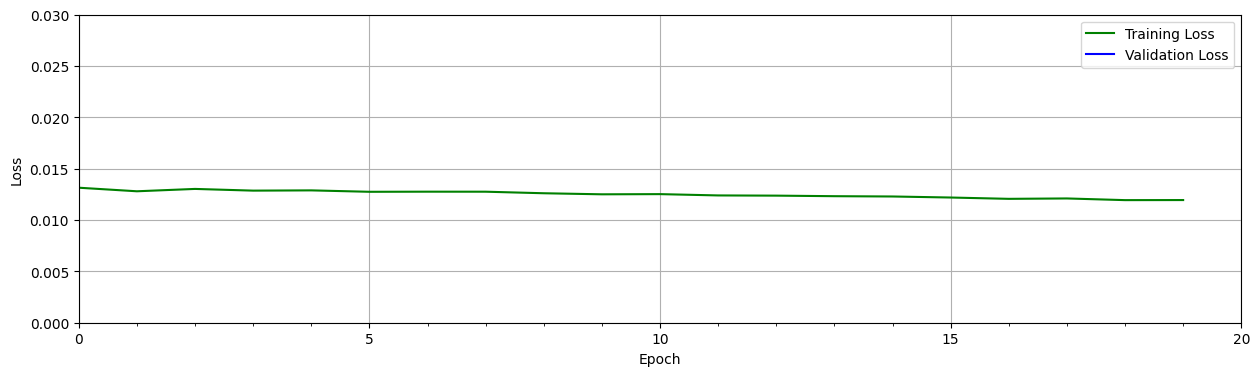

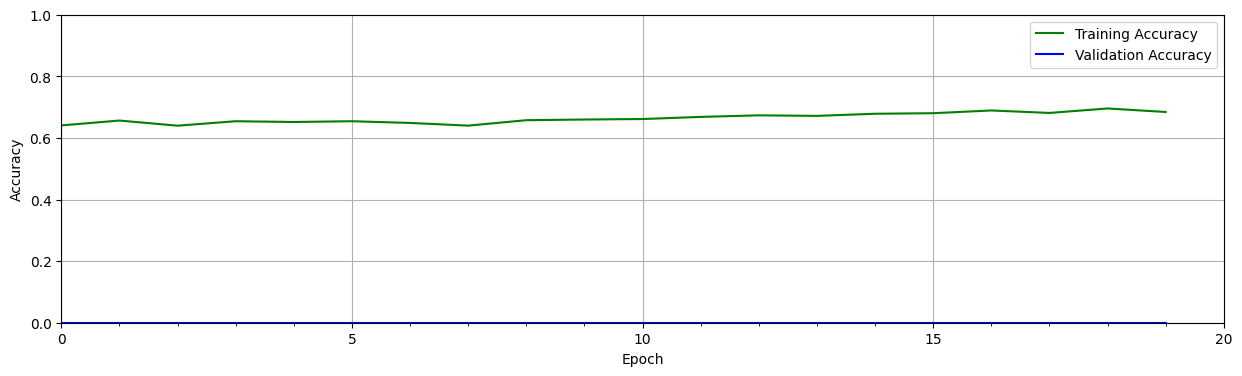

In [77]:
#Retrieve training results.
train_loss = eff_history.history["loss"]
train_acc  = eff_history.history["acc"]
valid_loss = eff_history.history["val_loss"]
valid_acc  = eff_history.history["val_acc"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 0.03],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [76]:
reloaded_model_dropout = models.load_model('efficientnet_WB')
test_loss, test_acc = reloaded_model_dropout.evaluate(x_test, y_test)
print(f"Test accuracy (model without dropout): {test_acc*100:.3f}")

181/181 [==============================] - 31s 154ms/step - loss: 0.0312 - acc: 0.1155
Test accuracy (model without dropout): 11.550


In [83]:
epoch = 40
eff_history = model.fit(x_train,
                        y_train,
                        batch_size=256, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_split=.25)

model.save('efficientnet_WB_1')

Epoch 1/40
18/18 [==============================] - 82s 5s/step - loss: 0.0407 - acc: 0.0100 - val_loss: 0.2978 - val_acc: 0.0013
Epoch 2/40
18/18 [==============================] - 81s 5s/step - loss: 0.0373 - acc: 0.0120 - val_loss: 0.2199 - val_acc: 0.0000e+00
Epoch 3/40
18/18 [==============================] - 85s 5s/step - loss: 0.0346 - acc: 0.0220 - val_loss: 0.1561 - val_acc: 6.6800e-04
Epoch 4/40
18/18 [==============================] - 81s 5s/step - loss: 0.0328 - acc: 0.0379 - val_loss: 0.1008 - val_acc: 0.0000e+00
Epoch 5/40
18/18 [==============================] - 83s 5s/step - loss: 0.0310 - acc: 0.0548 - val_loss: 0.0736 - val_acc: 0.0000e+00
Epoch 6/40
18/18 [==============================] - 99s 5s/step - loss: 0.0292 - acc: 0.0755 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 7/40
18/18 [==============================] - 100s 6s/step - loss: 0.0278 - acc: 0.0975 - val_loss: 0.0496 - val_acc: 0.0000e+00
Epoch 8/40
18/18 [==============================] - 78s 4s/step -

INFO:tensorflow:Assets written to: efficientnet_WB_1\assets


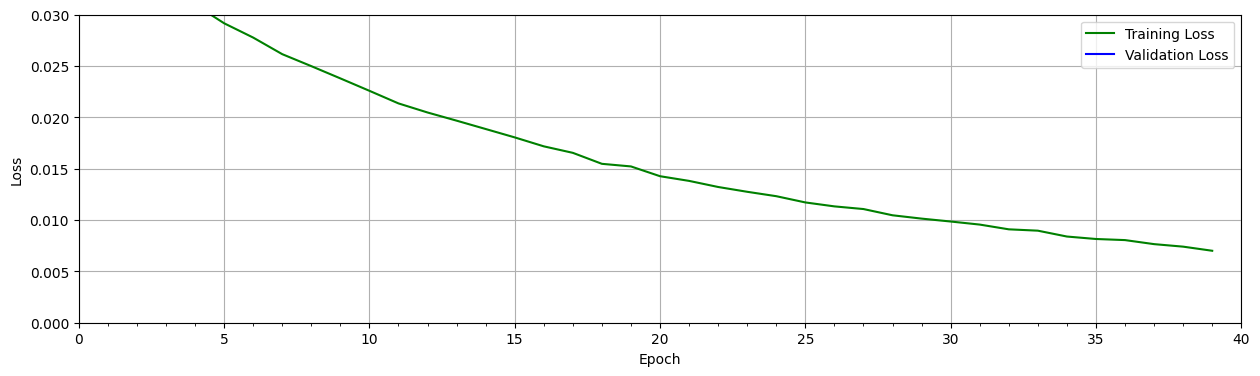

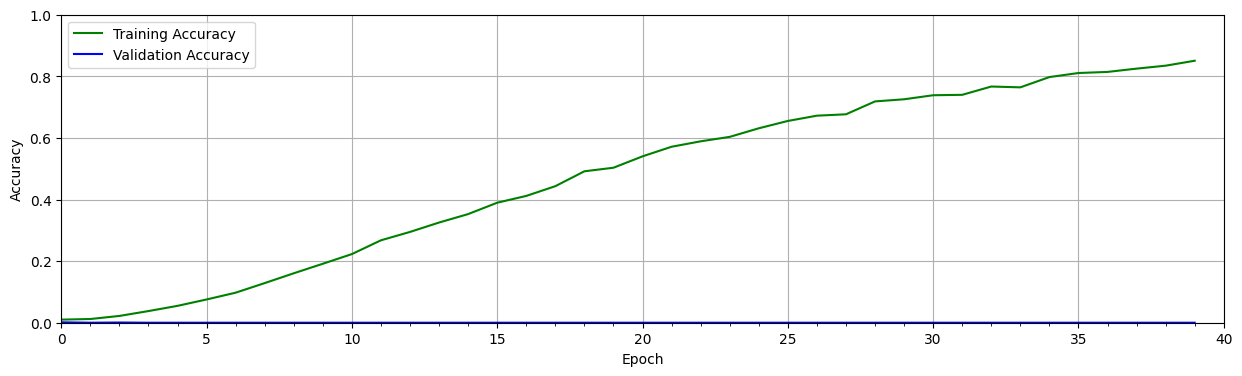

In [84]:
#Retrieve training results.
train_loss = eff_history.history["loss"]
train_acc  = eff_history.history["acc"]
valid_loss = eff_history.history["val_loss"]
valid_acc  = eff_history.history["val_acc"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 0.03],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [85]:
reloaded_model_dropout = models.load_model('efficientnet_WB_1')
test_loss, test_acc = reloaded_model_dropout.evaluate(x_test, y_test)
print(f"Test accuracy (model without dropout): {test_acc*100:.3f}")

181/181 [==============================] - 29s 147ms/step - loss: 0.0341 - acc: 0.1493
Test accuracy (model without dropout): 14.934


In [58]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 32, 32, 32)           864       ['input_4[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 32, 32, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 32, 32, 32)           0         ['stem_bn[0][0]']       